# Ultimate Inc

## Part 3 of Data Science Challenge

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

### Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Data Wrangling and Exploratory Data Analysis

In [137]:
# Load data
df = pd.read_json('ultimate_data_challenge.json')
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0


In [138]:
# Inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [139]:
# Check for missing data
df.isnull().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

In [140]:
# avg_rating_of_driver
df.avg_rating_of_driver.value_counts(dropna=False)

5.0    20771
NaN     8122
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
1.9        1
2.2        1
1.6        1
Name: avg_rating_of_driver, dtype: int64

In [141]:
# phone
df.phone.value_counts(dropna=False)

iPhone     34582
Android    15022
NaN          396
Name: phone, dtype: int64

In [142]:
# avg_rating_by_driver
df.avg_rating_by_driver.value_counts(dropna=False)

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
NaN      201
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
2.7        2
3.2        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

Plan to fill both of the missing ratings by using the overall averages for each column. 
However, will do this later after the test train split to avoid data leakage.
Assuming the missing phone values means it's some other type of carrier.

In [143]:
df.phone = df.phone.fillna('other')
df.phone.value_counts(dropna=False)

iPhone     34582
Android    15022
other        396
Name: phone, dtype: int64

In [144]:
# Fix date time data types.
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [145]:
# Consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
max_last_trip_date = df.last_trip_date.max()
active_cutoff_date = max_last_trip_date - pd.Timedelta(days=30)
print(f'The dates to determine if a user is active are from {active_cutoff_date.strftime("%b %d, %Y")} to {max_last_trip_date.strftime("%b %d, %Y")}.')

The dates to determine if a user is active are from Jun 01, 2014 to Jul 01, 2014.


In [146]:
# Create target feature is_user_retained.
df["is_user_retained"] = df.last_trip_date > active_cutoff_date
df.is_user_retained.value_counts()

False    31690
True     18310
Name: is_user_retained, dtype: int64

In [147]:
# Question: What fraction of the observed users were retained?
# Answer: 36.62%
df.is_user_retained.value_counts(normalize=True)

False    0.6338
True     0.3662
Name: is_user_retained, dtype: float64

<AxesSubplot:>

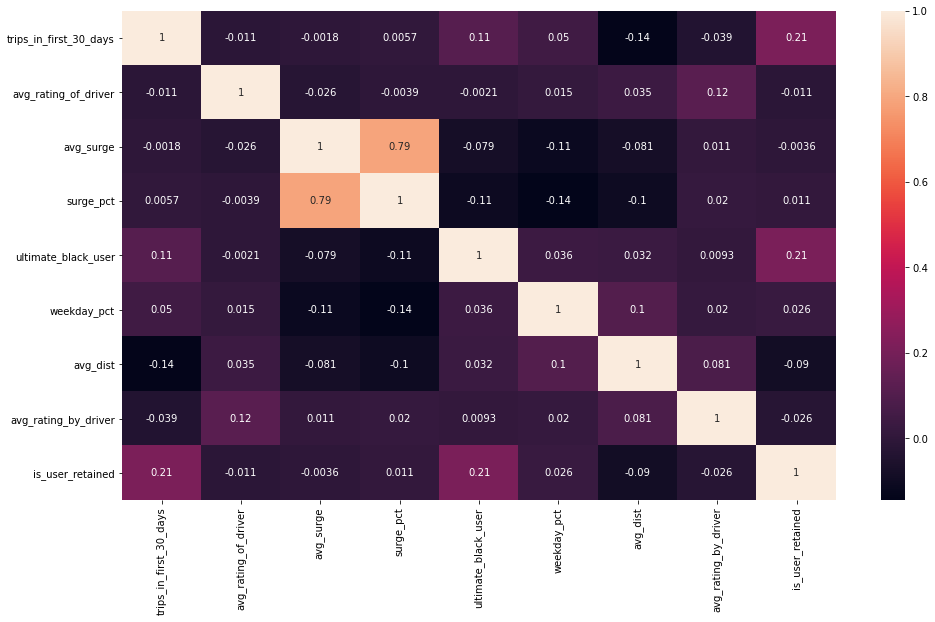

In [148]:
# Looking for correlation
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [149]:
# Summary statistics
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


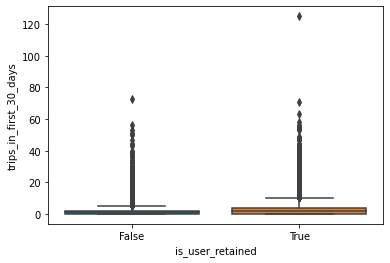

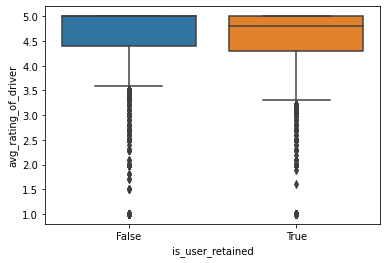

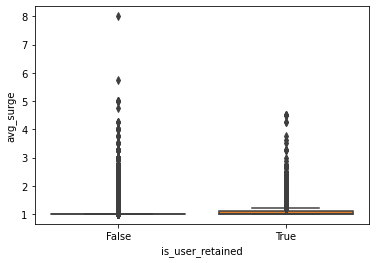

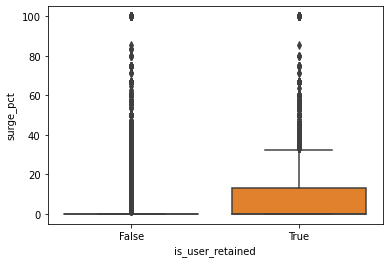

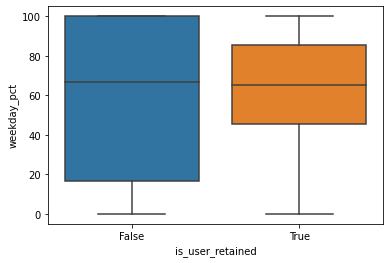

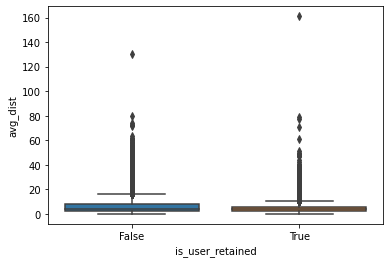

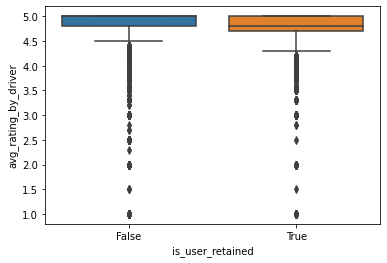

In [150]:
# There are some outliers here. Using box plots to explore further.
numeric_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
for col in numeric_features:
    sns.boxplot(y=df[col], x=df['is_user_retained'])
    plt.show()

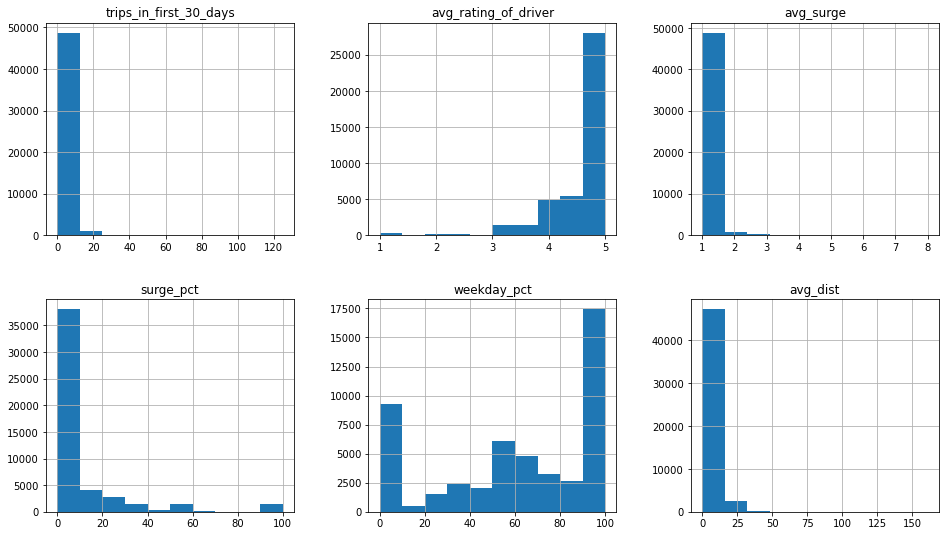

In [151]:
# There are so many outliers in the data will try plotting some other ways to explore further.
def plot_histogram():
    """
    Code copied from: pandas histogram: plot histogram for each column as subplot of a big figure
    at: https://stackoverflow.com/questions/39646070/pandas-histogram-plot-histogram-for-each-column-as-subplot-of-a-big-figure)
    """
    fig, axes = plt.subplots(len(numeric_features)//3, 3, figsize=(16, 9))
    
    i = 0
    for triaxis in axes:
        for axis in triaxis:
            df.hist(column = numeric_features[i], ax=axis)
            i = i+1

plot_histogram()

In [152]:
# city
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

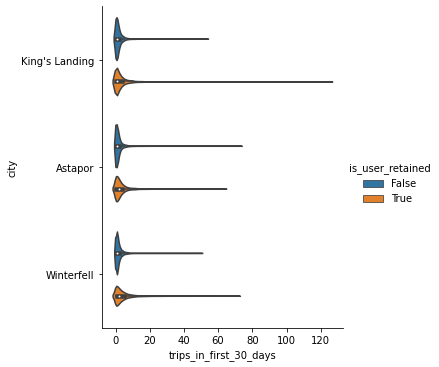

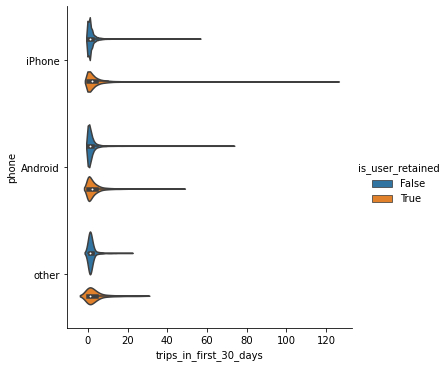

In [153]:
# Plot analysis for categories for 'trips_in_first_30_days'.
# Referenced http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
category_features = ['city', 'phone']
for cf in category_features:
    sns.catplot(y=cf, x='trips_in_first_30_days', hue='is_user_retained', kind='violin', data=df)
    plt.show()

In [154]:
# Date time need to be numeric for model later on.
df.signup_date = pd.to_numeric(df.signup_date)
df.last_trip_date = pd.to_numeric(df.last_trip_date)
# One hot encode city categories
df_cleaned = pd.get_dummies(df, prefix=['city', 'phone_OS'], columns=['city', 'phone'])
df_cleaned.head(3)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_user_retained,city_Astapor,city_King's Landing,city_Winterfell,phone_OS_Android,phone_OS_iPhone,phone_OS_other
0,4,1390608000000000000,4.7,1.1,1402963200000000000,15.4,True,46.2,3.67,5.0,True,0,1,0,0,1,0
1,0,1390953600000000000,5.0,1.0,1399248000000000000,0.0,False,50.0,8.26,5.0,False,1,0,0,1,0,0
2,3,1388966400000000000,4.3,1.0,1389052800000000000,0.0,False,100.0,0.77,5.0,False,1,0,0,0,1,0


In [155]:
# All features are now numeric for model analysis.
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  int64  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  is_user_retained        50000 non-null  bool   
 11  city_Astapor            50000 non-null  uint8  
 12  city_King's Landing     50000 non-null  uint8  
 13  city_Winterfell         50000 non-null  uint8  
 14  phone_OS_Android        50000 non-null

### Pre-process, Train, and Evaluate Models 

In [156]:
# Train/Test split to help avoid overfitting model to specific data.
X = df_cleaned.drop(['is_user_retained', 'last_trip_date'], axis=1)
y = df_cleaned['is_user_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

print(f"80% of data in X train {X_train.shape} and y train {y_train.shape}.")
print(f"Remaining in X test {X_test.shape} and y test {y_test.shape}.")

X train shape of (40000, 15) should relate to y train shape of (40000,).
X test shape of (10000, 15) should relate to y test shape of (10000,).


In [157]:
# Now it is time to calculate the missing values for the rating columns that have missing values.
training_overall_avg_rating_of_driver = X_train['avg_rating_of_driver'].mean()
training_overall_avg_rating_by_driver = X_train['avg_rating_by_driver'].mean()

# Following recommendations at https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy.
X_train_cleaned = X_train.copy()
mask = X_train_cleaned.avg_rating_of_driver.isnull()
X_train_cleaned.loc[mask, 'avg_rating_of_driver'] = training_overall_avg_rating_of_driver
mask = X_train_cleaned.avg_rating_by_driver.isnull()
X_train_cleaned.loc[mask, 'avg_rating_by_driver'] = training_overall_avg_rating_by_driver

# If there were even more features that needed this type of imputation would use the recommendations at https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py. 
X_test_cleaned = X_test.copy()
mask = X_test_cleaned.avg_rating_of_driver.isnull()
# Note that the training mean is still used here to avoid possible data leakage.
X_test_cleaned.loc[mask, 'avg_rating_of_driver'] = training_overall_avg_rating_of_driver
mask = X_test_cleaned.avg_rating_by_driver.isnull()
X_test_cleaned.loc[mask, 'avg_rating_by_driver'] = training_overall_avg_rating_by_driver

print(f'Overall mean of avg_rating_of_driver in training set is {training_overall_avg_rating_of_driver}.')
print(f'Overall mean of avg_rating_by_driver in training set is {training_overall_avg_rating_by_driver}.')

Overall mean of avg_rating_of_driver in training set is 4.602185074626784.
Overall mean of avg_rating_by_driver in training set is 4.778728103197113.


In [160]:
# Scale training and test data
scaler = preprocessing.StandardScaler().fit(X_train_cleaned)
X_train_cleaned_scaled = scaler.transform(X_train_cleaned)
X_test_cleaned_scaled = scaler.transform(X_test_cleaned)

Choosing to use Random forest for this supervised learning classification problem because:
- it performs well in a multitude of data situations.
- it uses an ensemble of decision trees.
- it is an efficient way to investigate the importance of a set of features with a large data set.
- dimensionality reduction helps find relevant details.

In [197]:
base_rf = RandomForestClassifier(n_estimators=10, random_state=123)
base_rf.fit(X_train_cleaned_scaled, y_train)
y_pred = base_rf.predict(X_test_cleaned_scaled)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Baseline Model - Random Forest Classifier")
print(f'Accuracy: {ac:.4f}.')
print(f'Weighted F1-score: {f1:.4f}.')

Baseline Model - Random Forest Classifier
Accuracy: 0.7583.
Weighted F1-score: 0.7524.


<AxesSubplot:>

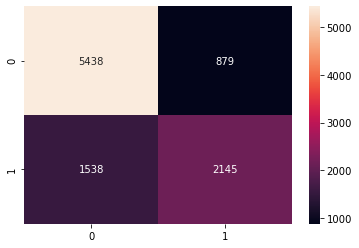

In [198]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [200]:
# Additional feature engineering to identify most important features
feat_importances = pd.Series(base_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_importances)

avg_dist                  0.209751
signup_date               0.132300
weekday_pct               0.106741
avg_rating_by_driver      0.106086
surge_pct                 0.079867
trips_in_first_30_days    0.078144
avg_rating_of_driver      0.072584
avg_surge                 0.062939
city_King's Landing       0.050379
ultimate_black_user       0.031268
phone_OS_Android          0.025488
city_Astapor              0.017629
phone_OS_iPhone           0.016877
city_Winterfell           0.008810
phone_OS_other            0.001138
dtype: float64


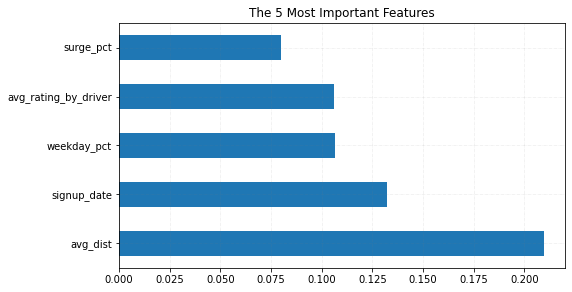

In [218]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 4.5))
feat_importances.nlargest(5).plot(kind='barh')
# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
plt.title("The 5 Most Important Features")
plt.show()

Referenced from https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd.
#### Tips to Improve a Machine Learning Model
There are three general approaches for improving an existing machine learning model:
1. Use more (high-quality) data and feature engineering
2. Tune the hyperparameters of the algorithm
3. Try different algorithms

In [175]:
# Determine which features are most important
# List of features for later use
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(base_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:} Importance: {}'.format(*pair))

Variable: avg_dist Importance: 0.21
Variable: signup_date Importance: 0.13
Variable: weekday_pct Importance: 0.11
Variable: avg_rating_by_driver Importance: 0.11
Variable: trips_in_first_30_days Importance: 0.08
Variable: surge_pct Importance: 0.08
Variable: avg_rating_of_driver Importance: 0.07
Variable: avg_surge Importance: 0.06
Variable: city_King's Landing Importance: 0.05
Variable: ultimate_black_user Importance: 0.03
Variable: phone_OS_Android Importance: 0.03
Variable: city_Astapor Importance: 0.02
Variable: phone_OS_iPhone Importance: 0.02
Variable: city_Winterfell Importance: 0.01
Variable: phone_OS_other Importance: 0.0


Text(0.5, 1.0, 'Variable Importances')

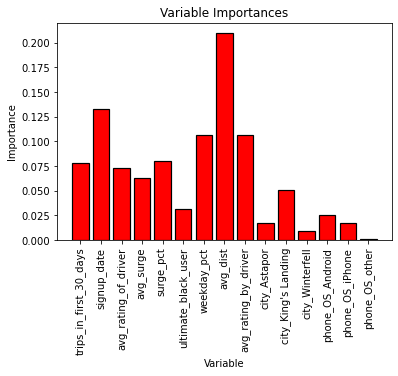

In [176]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Text(0.5, 1.0, 'Cumulative Importances')

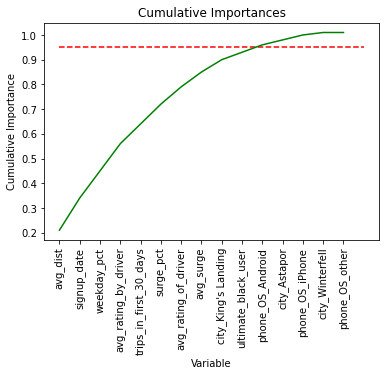

In [190]:
# Arbitrary most import feature cutoff
feature_importance_percentage = 0.95
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at % of importance retained
plt.hlines(y = feature_importance_percentage, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
plt.show()

In [191]:
# Find number of features for cumulative importance.
print(f'Number of features for {feature_importance_percentage * 100:.0f}% importance:', np.where(cumulative_importances > feature_importance_percentage)[0][0] + 1)

Number of features for 95% importance: 11


In [192]:
# Decrease the number of features from 15 to 11.
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:11]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = X_train_cleaned_scaled[:, important_indices]
important_test_features = X_test_cleaned_scaled[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (40000, 11)
Important test features shape: (10000, 11)


In [196]:
# Retrain using only the most important features.
important_features_rf = RandomForestClassifier(n_estimators=10, random_state=123)
important_features_rf.fit(important_train_features, y_train)
y_pred = important_features_rf.predict(important_test_features)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Most Important Features - Random Forest Classifier")
print(f'Accuracy: {ac:.4f}.')
print(f'Weighted F1-score: {f1:.4f}.')

Most Important Features - Random Forest Classifier
Accuracy: 0.7564.
Weighted F1-score: 0.7505.


<AxesSubplot:>

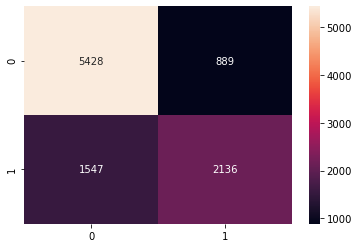

In [194]:
# Reducing the number of features slightly reduced the accuracy of the models; however, it also made the performance slightly faster.
# Since this is a smaller dataset it probably doesn't matter much either way; but in production this could be a very important additional step.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [162]:
# Now, using RandomizedSearchCV to help find the best hyperparameters for the model to improve the evaluation metrics.
# Used recommendations from article at: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=123)
clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 123, n_jobs = -1)
clf.fit(X_train_cleaned_scaled, y_train)

print("RandomizedSearchCV - Random Forest Classifier")
print(f"Best Accuracy Score: {str(clf.best_score_)}.")
print(f"Best Parameters: {str(clf.best_params_)}.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Random Forest Classifier
Best Accuracy Score: 0.7878250109845067.
Best Parameters: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}.


In [168]:
# Now using GridSearchCV to concentrate on combinations related to the best parameters above.
param_grid = {
    'n_estimators': [1600, 2100, 3000],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [3],
    'max_depth': [10],
    'bootstrap': [False]
}

rf_cv = RandomForestClassifier(random_state=123)
grid_search = GridSearchCV(estimator = rf_cv, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_cleaned_scaled, y_train)

print("GridSearchCV - Random Forest Classifier")
print(f"Best Accuracy Score: {str(grid_search.best_score_)}.")
print(f"Best Parameters: {str(grid_search.best_params_)}.")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
GridSearchCV - Random Forest Classifier
Best Accuracy Score: 0.7878250109845067.
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1600}.


In [170]:
# Stopping the evaluations here because GridSearchCV returned the same best results as the RandomizedSearchCV.
y_pred = grid_search.predict(X_test_cleaned_scaled)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best Random Forest Classifier")
print(f'Accuracy: {ac:.4f}.')
print(f'Weighted F1-score: {f1:.4f}.')

GridSearchCV - Random Forest Classifier
Accuracy: 0.7882.
Weighted F1-score: 0.7846.


<AxesSubplot:>

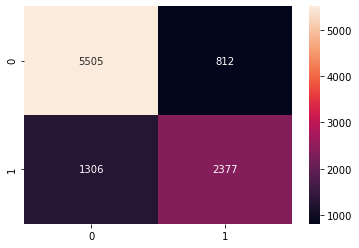

In [171]:
cm_gs = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_gs, annot=True, fmt='d')
plt.show()

In [213]:
# The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems.
y_pred_prob = grid_search.predict_proba(X_test_cleaned_scaled)[:, 1]
print(f"The Area Under the Curve is {round(roc_auc_score(y_test, y_pred_prob), 4)}.")

The Area Under the Curve is 0.8534.


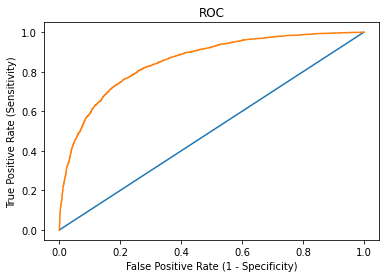

In [215]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC")
plt.show()